# **DAT 402: Project 2**  
**Identifying Musical Instruments Using Machine Learning**  
**By David Bonsaver and Andrew Nagle**  

## **Problem Statement**  
The objective of this project is to build a model capable of classifying images of musical instruments with high accuracy. Given an image, the model should correctly identify one of 30 instrument categories. This capability has several practical applications, such as:  

- **Automatic tagging** of musical instrument images in digital databases.  
- **Assistance for visually impaired individuals** by providing auditory descriptions of instruments.  
- **Enhancement of digital music libraries** through efficient categorization.  

## **Dataset Description**  
Our dataset consists of a total of **5,093 images**, spanning 30 different musical instrument categories. The images are in **JPEG format** with dimensions **224x224 pixels and 3 RGB channels**. The dataset is structured into three main subsets:  

- **Training Set (train/)** – 4,793 labeled images for model training.  
- **Validation Set (valid/)** – 150 images used for hyperparameter tuning.  
- **Test Set (test/)** – 150 images reserved for final model evaluation.  

Each of these directories contains 30 subdirectories, one for each instrument class. The dataset includes a diverse range of **string, wind, percussion, and brass instruments**, such as guitars, saxophones, violins, flutes, trumpets, and drums.  

## **Objectives**  
This project aims to:  

- **Perform Exploratory Data Analysis (EDA):** Analyze dataset distribution and visualize key insights.  
- **Apply Unsupervised Learning:** Utilize clustering methods (e.g., K-Means) and dimensionality reduction techniques (PCA, t-SNE) to explore patterns in image features.  
- **Develop Supervised Learning Models:** Train and compare different deep learning architectures, including a **custom CNN** and a **pre-trained ResNet50 model** for classification.  
- **Evaluate Model Performance:** Use metrics such as **accuracy, precision-recall, and confusion matrices** to assess misclassifications and overall effectiveness.  
- **Interpret Results & Discuss Future Improvements:** Analyze model outputs, identify challenges, and propose enhancements for increased accuracy and generalization.  


## **Importing Libraries and Setting Up the Environment**  

To begin the project, we import the necessary Python libraries for data processing, visualization, clustering, model building, and evaluation.  

### **Key Libraries Used:**
- **Data Handling:** `numpy`, `pandas`
- **Visualization:** `matplotlib`, `seaborn`, `plotly`
- **Parallel Processing:** `ThreadPoolExecutor` (for efficient file handling)
- **Machine Learning:** `scikit-learn` (for clustering, dimensionality reduction, and evaluation metrics)
- **Deep Learning:** `tensorflow.keras` (for building and training CNN models)
- **File Operations:** `os`, `glob`, `cv2` (for dataset management)

---







In [ ]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
import seaborn as sns
import os
import random
import glob
import cv2
from collections import Counter
from IPython.display import display
from concurrent.futures import ThreadPoolExecutor
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score, confusion_matrix, classification_report, ConfusionMatrixDisplay, accuracy_score
from sklearn.utils.class_weight import compute_class_weight
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.data import AUTOTUNE
from pathlib import Path
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import LabelEncoder

## **Ensuring Reproducibility**  

A **global seed (`GLOBAL_SEED = 123`)** is set to ensure that all random operations (e.g., dataset splitting, model initialization) produce consistent results. This is applied to:
- `numpy` for numerical operations  
- `tensorflow` for deep learning processes  
- `random` for general randomness control  

This helps in replicability of experiments and fair model comparison.

In [ ]:
# Global seed for reproducibility
GLOBAL_SEED = 123

# Set seeds for all relevant libraries
np.random.seed(GLOBAL_SEED)
tf.random.set_seed(GLOBAL_SEED)
random.seed(GLOBAL_SEED)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Set directories for dataset
base_dir = "/content/drive/My Drive/DAT_402_Project_02/data/my_created_archive"

In [ ]:
# Define the directory containing the images
IMAGE_DIR = base_dir  # Updated path

# Function to extract the instrument name from the filename
def extract_label(filename):
    return filename.split('_')[0]  # Extracts the part before the first underscore

# Function to load and preprocess images
def load_images(image_dir, target_size=(64, 64)):
    image_files = [f for f in os.listdir(image_dir) if f.lower().endswith(('jpg', 'jpeg', 'png'))]
    data = []
    labels = []
    filepaths = []

    for file in image_files:
        img_path = os.path.join(image_dir, file)
        img = cv2.imread(img_path)
        if img is not None:  # Ensure the image is loaded correctly
            img = cv2.resize(img, target_size)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  # Convert to grayscale
            data.append(img.flatten())  # Flatten for ML processing
            labels.append(extract_label(file))
            filepaths.append(img_path)

    return np.array(data), np.array(labels), filepaths


# Load images
data, labels, filepaths = load_images(IMAGE_DIR)

## **Dataset Summary and Class Distribution Analysis**

Upon download the dataset was in a series of nested folders already split into 'train', 'test', 'valid' and some other misc folders. Inside each were subfolders named for each of the instruments inside, and then finally the actual jpg images, which had no distinguishing names. For our purposes, we wanted the raw jpg files. So we extracted all the images to one base fodler (**Filenames.py**), and renamed each jpg to contain the name of the instrument in question (as well as fix typos such as "Saxaphone ->saxophone (**Rename.py**). We can use the name of the file as our source of truth.

## **Dataset Summary and Class Distribution Analysis**

To better understand the dataset, we create functions to summarize and analyze the distribution of images across instrument classes.

## **Analyzing Class Distribution and Imbalances**
To evaluate dataset balance, we compute key statistics:
- **Minimum class size** – The least populated instrument category.
- **Maximum class size** – The most populated instrument category.



This step is critical for identifying potential class imbalances, which could impact model performance. If a class is significantly underrepresented, techniques such as **data augmentation** or **class weighting** may be needed to improve classification accuracy.



In [ ]:
def summarize_dataset(dataset_path):
    """Returns a DataFrame summarizing image counts per instrument (from filenames)."""
    if not os.path.exists(dataset_path):
        raise ValueError(f"Error: Directory '{dataset_path}' does not exist!")

    # Extract instrument names from filenames
    image_files = [f for f in os.listdir(dataset_path) if f.lower().endswith(('jpg', 'jpeg', 'png'))]
    instrument_labels = [f.split('_')[0] for f in image_files]  # Extract instrument names

    # Count occurrences of each instrument
    instrument_counts = Counter(instrument_labels)

    # Convert to DataFrame
    df = pd.DataFrame(instrument_counts.items(), columns=["Instrument", "Total Images"])
    df = df.sort_values(by="Total Images", ascending=False).reset_index(drop=True)

    return df

# Set the base directory (all images are in this single folder)
base_dir = "/content/drive/My Drive/DAT_402_Project_02/data/my_created_archive"

# Generate dataset summary
dataset_summary = summarize_dataset(base_dir)

# Display the dataset summary
display(dataset_summary)

,Instrument,Total Images
0,saxophone,285
1,steel drum,285
2,harp,285
3,maracas,285
4,ocarina,285
5,piano,285
6,trombone,285
7,trumpet,285
8,sitar,285
9,tuba,285


Our analysis revealed that the largest instrument class was 285 (after including all sets), and many instruments were below 150 images. Due to the limited images available, we opted to **augment** the data. by flipping and slightly stretching many of the images. The code used is located in **Sampling fix.py**


To inspect the dataset, a function selects **4 random instrument classes**, displaying **5 images per class** in a **4x5 grid**.  
- **OpenCV (`cv2`)** loads and converts images to RGB.  
- Missing or unreadable images are skipped.  

These visualizations help ensure **data integrity and balance** before model training.  


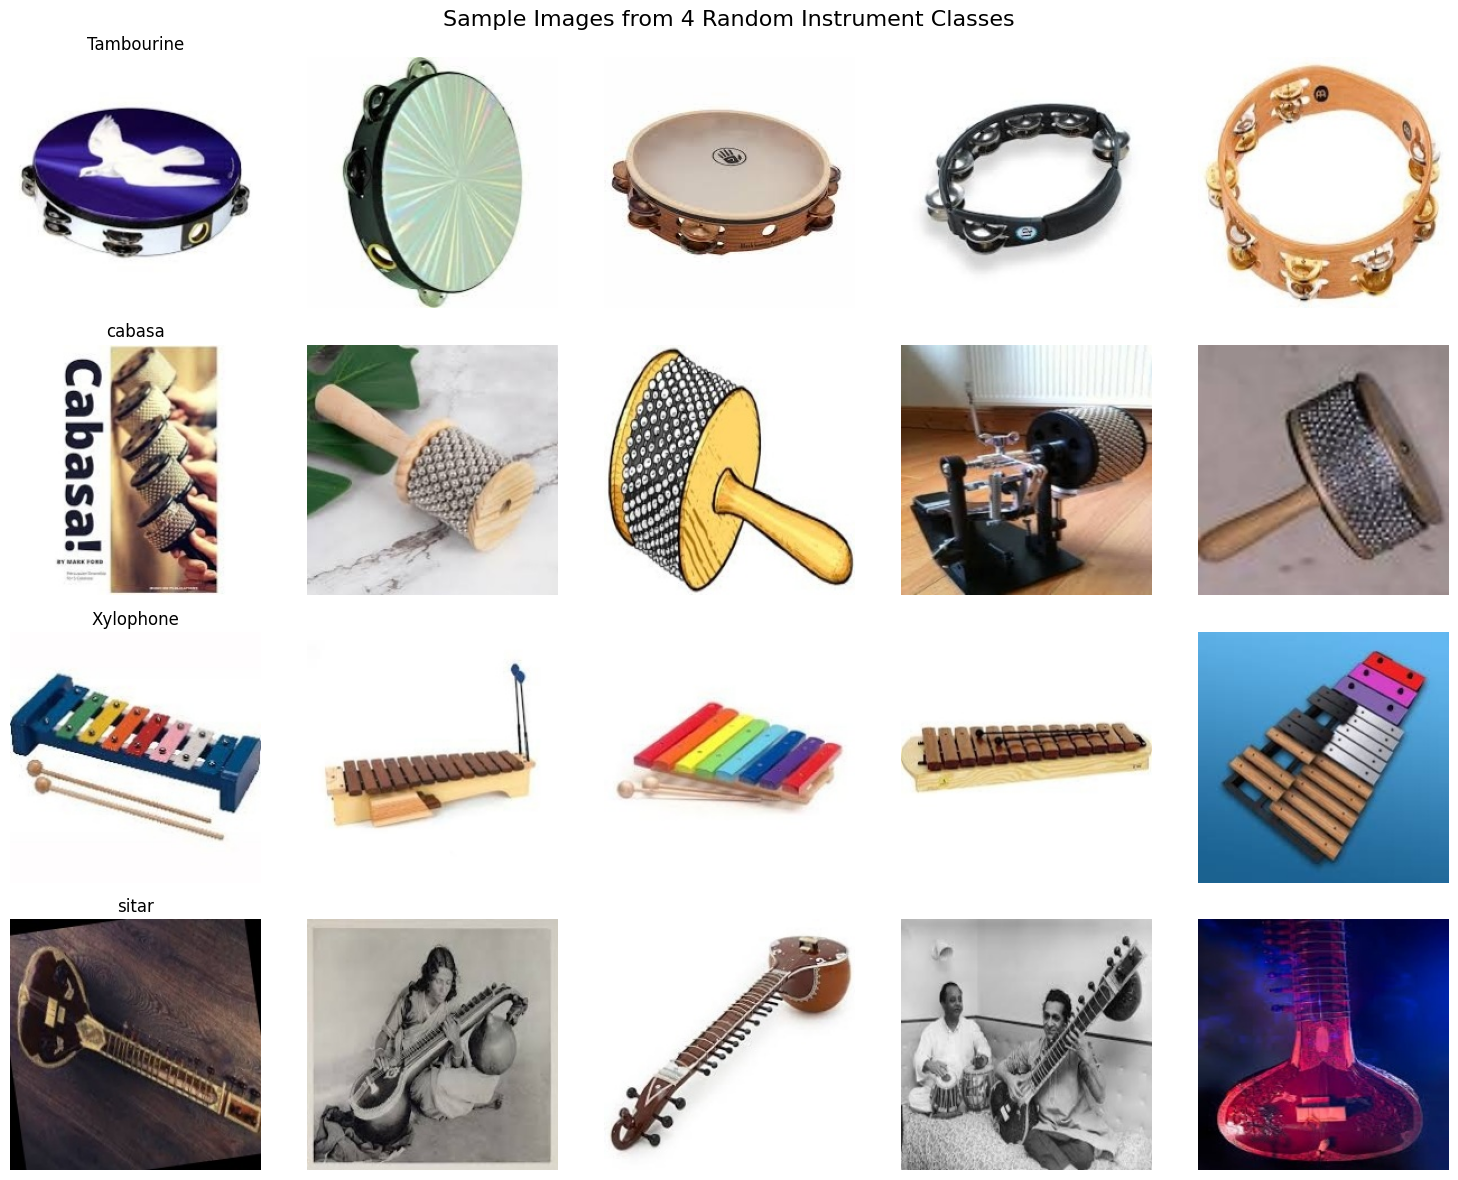

In [ ]:
# Function to extract instrument name from filename
def extract_label(filename):
    return filename.split('_')[0]  # Extracts the part before the first underscore

# Load image filenames
image_files = [f for f in os.listdir(base_dir) if f.lower().endswith(('jpg', 'jpeg', 'png'))]

# Extract labels and create class mapping
labels = [extract_label(f) for f in image_files]
class_to_index = {cls: i for i, cls in enumerate(sorted(set(labels)))}

# Function to show a fixed 4x5 grid of sample images (random selection)
def show_sample_images(dataset_path, class_to_index, num_samples=5):
    """Displays a 4x5 grid of sample images randomly chosen from 4 different instrument classes."""

    # Select 4 random classes from the dataset
    selected_classes = random.sample(list(class_to_index.keys()), min(len(class_to_index), 4))

    fig, axes = plt.subplots(4, 5, figsize=(5 * 3, 4 * 3))
    fig.suptitle("Sample Images from 4 Random Instrument Classes", fontsize=16)

    for i, cls in enumerate(selected_classes):
        # Get all image files belonging to the selected class
        image_files = [f for f in os.listdir(dataset_path) if f.startswith(cls) and f.lower().endswith(('jpg', 'jpeg', 'png'))]

        if not image_files:
            print(f"Warning: No images found for {cls}, skipping...")
            continue

        # Select a subset of images from the class
        sample_images = random.sample(image_files, min(num_samples, len(image_files)))

        for j, img_file in enumerate(sample_images):
            img_path = os.path.join(dataset_path, img_file)
            img = cv2.imread(img_path)

            if img is None:
                print(f"Warning: Could not read {img_path}, skipping...")
                continue  # Skip unreadable images

            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            axes[i, j].imshow(img)
            axes[i, j].axis('off')

            if j == 0:
                axes[i, j].set_title(cls, fontsize=12)

    # Hide any unused subplots if fewer than 4 classes exist
    for i in range(len(selected_classes), 4):
        for j in range(5):
            axes[i, j].axis('off')

    plt.tight_layout()
    plt.show()

# Display a random 4x5 grid of sample images
show_sample_images(base_dir, class_to_index)

## **Unsupervised Learning: Dimensionality Reduction & Clustering**

### **1. Principal Component Analysis (PCA)**
- **Reduces dimensionality** while retaining key variance.
- We retain **50 principal components** for efficient processing.
- A **Scree Plot** visualizes the cumulative explained variance to determine the optimal number of components.

### **2. t-SNE for Visualization**
- **Further reduces dimensionality** to **2D** for visualization.
- Helps uncover **patterns and clusters** in the dataset.

### **3. K-Means Clustering**
- Clusters the data into **predefined categories** based on the number of unique labels.
- **Cluster assignments** are used to color data points in the t-SNE plot.

### **4. Visualizations**
- **t-SNE Plot:** Displays instrument clusters using K-Means labels.
- **PCA Scree Plot:** Helps determine how many components to retain.
- **Enhanced t-SNE Plot:** Adds sample instrument labels to improve interpretability.

These techniques provide insights into **dataset structure, similarities, and potential class separability** before supervised learning.


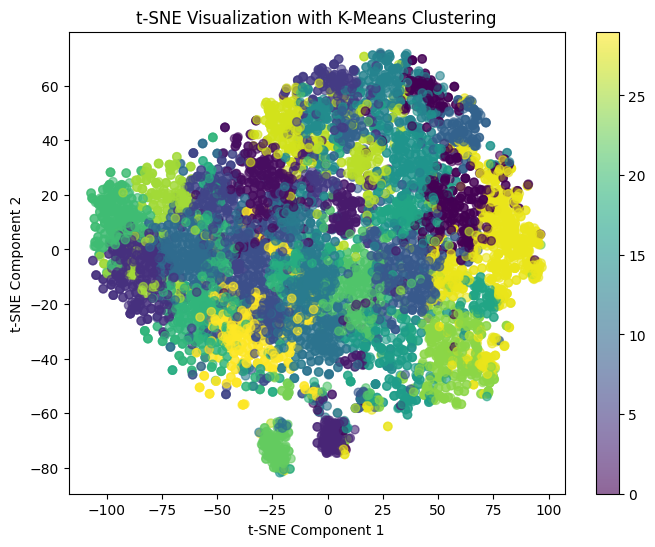

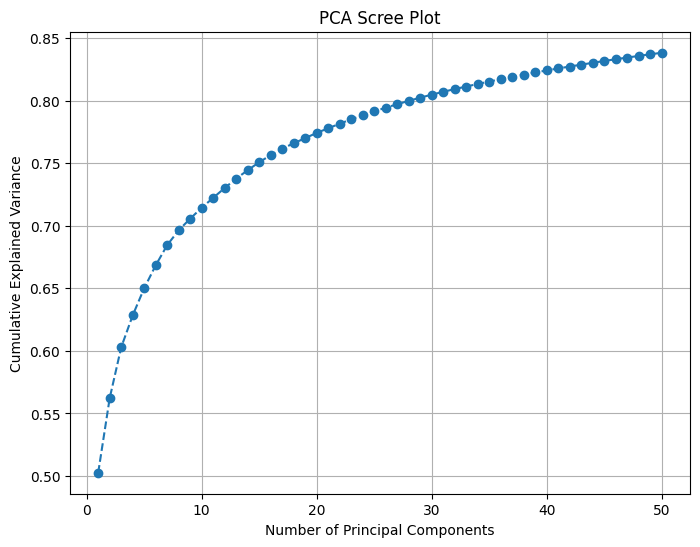

In [ ]:
# Perform non-supervised learning - PCA for dimensionality reduction
pca = PCA(n_components=50)
X_pca = pca.fit_transform(data)

# Perform t-SNE for visualization
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_pca)

# Perform K-Means clustering
num_clusters = len(set(labels))  # Assuming the number of unique labels
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans_labels = kmeans.fit_predict(X_pca)

# Visualize t-SNE with K-Means clustering
plt.figure(figsize=(8, 6))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=kmeans_labels, cmap='viridis', alpha=0.6)
plt.title('t-SNE Visualization with K-Means Clustering')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.colorbar()
plt.show()

# PCA Component Analysis - Scree Plot
plt.figure(figsize=(8, 6))
plt.plot(range(1, 51), np.cumsum(pca.explained_variance_ratio_), marker='o', linestyle='--')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Scree Plot')
plt.grid()
plt.show()

## **Supervised Learning: Classification Models**

To classify musical instruments, we apply three supervised learning models and compare their performance.

### **1. Data Splitting**
- **80% training, 20% testing** split using `train_test_split()`.
- **Stratified sampling** ensures balanced class representation.

### **2. Decision Tree Classifier**
- Trained on **PCA-transformed data** to make hierarchical decisions.
- Predictions are evaluated using **accuracy** and a **classification report**.

### **3. Random Forest Classifier**
- Uses **100 decision trees** to improve robustness.
- Provides better generalization than a single decision tree.

### **4. Neural Network (MLP)**
- A **Multi-Layer Perceptron (MLP)** with:
  - **Two hidden layers** (128 and 64 neurons).
  - **ReLU activation** and **Adam optimizer**.
  - Trained for **500 iterations**.
- Labels are **encoded** using `LabelEncoder()`.

### **5. Performance Comparison**
- **Accuracy scores** for all models.
- **Classification reports** provide precision, recall, and F1-score insights.

This comparison helps determine the most effective model before transitioning to deep learning techniques.


In [ ]:
# Split dataset into training and testing
X_train, X_test, y_train, y_test = train_test_split(X_pca, labels, test_size=0.2, random_state=42, stratify=labels)

# Train Decision Tree
dt_clf = DecisionTreeClassifier(random_state=42)
dt_clf.fit(X_train, y_train)

# Predict with Decision Tree
y_pred_dt = dt_clf.predict(X_test)

# Train a RandomForest model
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Predict on test set
y_pred_rf = clf.predict(X_test)

# Train a Neural Network using MLPClassifier
encoder = LabelEncoder()
y_train_encoded = encoder.fit_transform(y_train)
y_test_encoded = encoder.transform(y_test)

mlp = MLPClassifier(hidden_layer_sizes=(256, 128, 64), activation='relu', solver='adam', max_iter=500, random_state=42, early_stopping=True)
mlp.fit(X_train, y_train_encoded)

# Predict using Neural Network
y_pred_mlp = mlp.predict(X_test)
mlp_accuracy = accuracy_score(y_test_encoded, y_pred_mlp)
rf_accuracy = accuracy_score(y_test, y_pred_rf)

# Compare Results
print("\nDecision Tree Performance:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_dt):.2f}")
print(classification_report(y_test, y_pred_dt))

print("\nRandom Forest Performance:")
print(f"Accuracy: {rf_accuracy:.2f}")
print(classification_report(y_test, y_pred_rf))

print("\nNeural Network (MLP) Performance:")
print(f"Accuracy: {mlp_accuracy:.2f}")
print(classification_report(y_test_encoded, y_pred_mlp))


Decision Tree Performance:
Accuracy: 0.50
              precision    recall  f1-score   support

  Didgeridoo       0.45      0.42      0.44        57
  Tambourine       0.44      0.32      0.37        57
   Xylophone       0.36      0.42      0.39        57
   accordion       0.62      0.42      0.50        57
     alphorn       0.50      0.47      0.49        57
    bagpipes       0.47      0.44      0.45        57
       banjo       0.54      0.49      0.51        57
  bongo drum       0.48      0.56      0.52        57
      cabasa       0.22      0.19      0.21        57
   castanets       0.67      0.65      0.66        57
    clarinet       0.42      0.51      0.46        57
  clavichord       0.45      0.44      0.44        57
  concertina       0.56      0.67      0.61        57
       drums       0.65      0.49      0.56        57
    dulcimer       0.49      0.63      0.55        57
       flute       0.39      0.42      0.40        57
       guiro       0.59      0.53     

# Generate confusion matrices
rf_cm = confusion_matrix(y_test, y_pred_rf)
mlp_cm = confusion_matrix(y_test_encoded, y_pred_mlp)

# Plot confusion matrices
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.heatmap(rf_cm, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title('Random Forest Confusion Matrix')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')

sns.heatmap(mlp_cm, annot=True, fmt='d', cmap='Oranges', ax=axes[1])
axes[1].set_title('Neural Network Confusion Matrix')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')

plt.show()

print("PCA, t-SNE, K-Means clustering, Decision Tree, RandomForest classification, and Neural Network training completed with comparative analysis.")


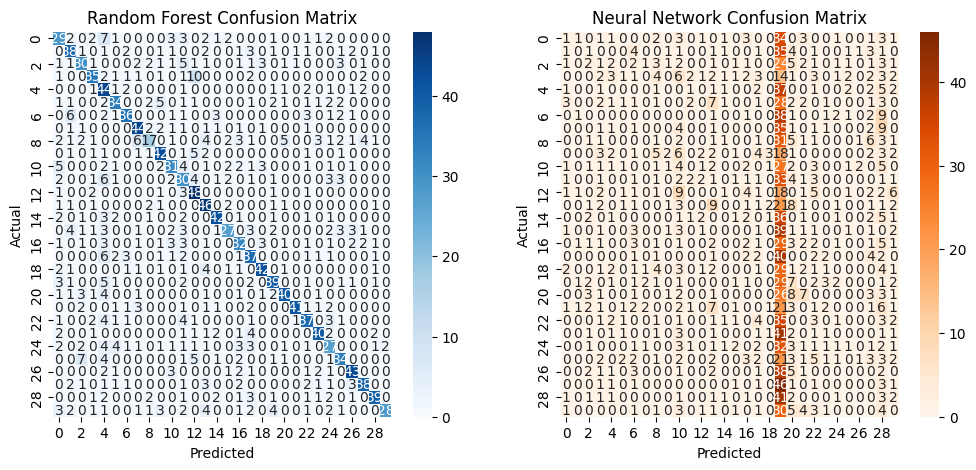

PCA, t-SNE, K-Means clustering, Decision Tree, RandomForest classification, and Neural Network training completed with comparative analysis.


In [ ]:
# Generate confusion matrices
rf_cm = confusion_matrix(y_test, y_pred_rf)
mlp_cm = confusion_matrix(y_test_encoded, y_pred_mlp)

# Plot confusion matrices
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.heatmap(rf_cm, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title('Random Forest Confusion Matrix')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')

sns.heatmap(mlp_cm, annot=True, fmt='d', cmap='Oranges', ax=axes[1])
axes[1].set_title('Neural Network Confusion Matrix')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')

plt.show()

print("PCA, t-SNE, K-Means clustering, Decision Tree, RandomForest classification, and Neural Network training completed with comparative analysis.")

our confusion matrix shows a vertical line, not good! Let's see what's going on

In [ ]:
# 1. Check PCA Explained Variance
explained_variance = np.sum(pca.explained_variance_ratio_)
print(f"Explained Variance Retained by PCA: {explained_variance:.2f}")

# 2. Check Label Encoding Issues (For Neural Network)
print("Class distribution in y_test_encoded:", Counter(y_test_encoded))
print("Class distribution in y_pred_mlp:", Counter(y_pred_mlp))

Explained Variance Retained by PCA: 0.84
Class distribution in y_test_encoded: Counter({1: 57, 27: 57, 10: 57, 29: 57, 19: 57, 7: 57, 18: 57, 16: 57, 11: 57, 9: 57, 0: 57, 6: 57, 8: 57, 4: 57, 13: 57, 24: 57, 25: 57, 14: 57, 17: 57, 22: 57, 5: 57, 23: 57, 26: 57, 15: 57, 3: 57, 20: 57, 21: 57, 2: 57, 12: 57, 28: 57})
Class distribution in y_pred_mlp: Counter({19: 926, 28: 98, 20: 78, 10: 69, 13: 51, 22: 42, 27: 41, 29: 36, 6: 33, 17: 32, 8: 31, 21: 31, 3: 29, 16: 26, 2: 21, 4: 21, 0: 16, 23: 15, 24: 14, 12: 12, 15: 12, 25: 11, 11: 10, 14: 10, 5: 10, 18: 9, 9: 8, 7: 7, 1: 6, 26: 5})


Our varience looks fine. Maybe adding more features would help. But notably class 19 is WAY overrepresented.

In [66]:
y_prob_mlp = mlp.predict_proba(X_test)
print(np.mean(y_prob_mlp, axis=0))  # Average probability per class


[0.03041054 0.02573002 0.03628014 0.03207201 0.03398207 0.02238146
 0.04416296 0.0213872  0.04668749 0.02810774 0.05276922 0.02752933
 0.02778441 0.04780881 0.02678048 0.02231137 0.03270787 0.0389375
 0.02499458 0.0318837  0.04376762 0.03398792 0.03640053 0.02488396
 0.02601118 0.02978226 0.02354905 0.03446369 0.05299568 0.03944922]


## **Data Preprocessing and Dataset Preparation for Simple and Advanced CNN**

### **1. Defining Batch Sizes and Image Processing Parameters**
- **Batch sizes**:  
  - Training: **32**  
  - Validation/Test: **30**  
- **Image Size**: Resized to **224×224** pixels for consistency.  

### **2. Extracting Labels and Encoding Classes**
- Labels are **extracted** from filenames.  
- A **class mapping dictionary** converts instrument names into numerical values.  
- The dataset is **shuffled** before splitting into **80% training, 10% validation, and 10% testing**.

### **3. Handling Class Imbalances**
- **Class weights** are computed using `compute_class_weight()` to **adjust for dataset imbalances** during training.  

### **4. Image Preprocessing for TensorFlow Pipeline**
- Images are **loaded, resized, and normalized** to [0,1] range.  
- Labels are **one-hot encoded** for model compatibility.  

### **5. Creating TensorFlow Datasets**
- **`tf.data.Dataset` pipelines** are built for:
  - **Training:** Shuffled, batched, and prefetched for efficiency.  
  - **Validation & Testing:** Batched and prefetched (no shuffling).  

These steps ensure an **optimized input pipeline** for deep learning models.

In [ ]:
# Define batch sizes
train_batch_size = 32
eval_batch_size = 30  # Matches val/test set size
img_size = (224, 224)  # Resize images

# Function to extract instrument label from filename
def extract_label(filename):
    return filename.split('_')[0]  # Extracts the part before the first underscore

# Load image filenames
image_files = [f for f in os.listdir(base_dir) if f.lower().endswith(('jpg', 'jpeg', 'png'))]

# Extract labels and store file paths
labels = [extract_label(f) for f in image_files]
filepaths = [os.path.join(base_dir, f) for f in image_files]

# Convert labels to numerical values
class_names = sorted(set(labels))  # Unique instrument names
class_to_index = {cls: i for i, cls in enumerate(class_names)}
numerical_labels = np.array([class_to_index[label] for label in labels])

# Print class mapping for verification
print("Class Mapping:", class_to_index)

# Shuffle data before splitting
indices = np.arange(len(filepaths))
np.random.shuffle(indices)

filepaths = np.array(filepaths)[indices]
numerical_labels = numerical_labels[indices]

# Define split sizes (80% Train, 10% Validation, 10% Test)
train_split = int(0.8 * len(filepaths))
valid_split = int(0.9 * len(filepaths))  # First 80% train, next 10% valid, last 10% test

# Split dataset
train_files, valid_files, test_files = filepaths[:train_split], filepaths[train_split:valid_split], filepaths[valid_split:]
train_labels, valid_labels, test_labels = numerical_labels[:train_split], numerical_labels[train_split:valid_split], numerical_labels[valid_split:]

# Compute class weights based on training data
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.array(list(class_to_index.values())),
    y=train_labels
)
class_weight_dict = {i: weight for i, weight in enumerate(class_weights)}

# Print computed class weights
print("Computed Class Weights:", class_weight_dict)

Class Mapping: {'Didgeridoo': 0, 'Tambourine': 1, 'Xylophone': 2, 'accordion': 3, 'alphorn': 4, 'bagpipes': 5, 'banjo': 6, 'bongo drum': 7, 'cabasa': 8, 'castanets': 9, 'clarinet': 10, 'clavichord': 11, 'concertina': 12, 'drums': 13, 'dulcimer': 14, 'flute': 15, 'guiro': 16, 'guitar': 17, 'harmonica': 18, 'harp': 19, 'maracas': 20, 'ocarina': 21, 'piano': 22, 'saxophone': 23, 'sitar': 24, 'steel drum': 25, 'trombone': 26, 'trumpet': 27, 'tuba': 28, 'violin': 29}
Computed Class Weights: {0: 1.0555555555555556, 1: 0.987012987012987, 2: 0.9956331877729258, 3: 1.0506912442396312, 4: 1.0, 5: 1.0044052863436124, 6: 1.0224215246636772, 7: 0.9827586206896551, 8: 1.0654205607476634, 9: 0.9743589743589743, 10: 1.0224215246636772, 11: 0.9702127659574468, 12: 1.0224215246636772, 13: 0.946058091286307, 14: 1.0555555555555556, 15: 0.9661016949152542, 16: 0.9956331877729258, 17: 1.0044052863436124, 18: 0.9785407725321889, 19: 1.0, 20: 1.027027027027027, 21: 0.9421487603305785, 22: 0.9785407725321889,

In [ ]:
# Function to load and preprocess images
def load_and_preprocess_image(filepath, label):
    img = tf.io.read_file(filepath)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, img_size)
    img = img / 255.0  # Normalize pixel values
    label = tf.one_hot(label, depth=len(class_names))  # One-hot encoding
    return img, label

# Training Dataset
train_dataset = tf.data.Dataset.from_tensor_slices((train_files, train_labels))
train_dataset = train_dataset.map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE)
train_dataset = train_dataset.shuffle(buffer_size=len(train_files)).batch(train_batch_size).prefetch(AUTOTUNE)

# Validation Dataset
valid_dataset = tf.data.Dataset.from_tensor_slices((valid_files, valid_labels))
valid_dataset = valid_dataset.map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE)
valid_dataset = valid_dataset.batch(eval_batch_size).prefetch(AUTOTUNE)

# Test Dataset (No shuffling, used for final evaluation)
test_dataset = tf.data.Dataset.from_tensor_slices((test_files, test_labels))
test_dataset = test_dataset.map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE)
test_dataset = test_dataset.batch(eval_batch_size).prefetch(AUTOTUNE)

## **Early Stopping for Model Training**

To **prevent overfitting** and **optimize training time**, we implement **early stopping**, which halts training when validation loss stops improving.

### **Key Parameters:**
- **`monitor="val_loss"`** – Tracks validation loss to determine stopping point.  
- **`patience=5`** – Stops training if no improvement is seen for **5 consecutive epochs**.  
- **`restore_best_weights=True`** – Ensures the model retains the best-performing weights.  
- **`verbose=1`** – Provides updates when early stopping is triggered.  

This technique helps achieve **better generalization** by preventing unnecessary training beyond the optimal point.

In [ ]:
# Define Early Stopping (stops training when validation loss stops improving)
early_stopping = EarlyStopping(
    monitor="val_loss",  # Track validation loss
    patience=5,  # Stop if no improvement for 5 epochs
    restore_best_weights=True,  # Restore best model
    verbose=1
)

## **Baseline Neural Network Model: `instrument_net01`**

We define and train a **simple Dense neural network** as a **baseline model** for instrument classification.

### **1. Model Architecture**
- **Input Layer:** Accepts images of shape **(224, 224, 3)**.
- **Flatten Layer:** Converts image data into a **1D vector**.
- **Hidden Layers:**  
  - **Four fully connected layers** with **ReLU activation** (150, 70, 50, 30 neurons).
- **Output Layer:**  
  - **30 neurons** (one per class) with **softmax activation** for multi-class classification.

### **2. Compilation & Training**
- **Optimizer:** Adam with a **learning rate of 0.0001**.
- **Loss Function:** Categorical Cross-Entropy.  
- **Metrics:** Accuracy.  
- **Early Stopping:** Monitors **validation loss** and restores the best model.

### **3. Training Results**
- **20 epochs** trained on the dataset with **class weights applied** to handle imbalance.
- **Progression:** Gradual improvement in accuracy and reduction in loss.
- **Final Validation Accuracy:** **~28.3%** (suggesting further model enhancements needed).

This model serves as a **starting point** before exploring more complex architectures like CNNs.

In [ ]:
# Use global seed for reproducibility
np.random.seed(GLOBAL_SEED)
tf.random.set_seed(GLOBAL_SEED)

# Define the number of instrument classes
num_classes = 30

# Define a simple Dense neural network (Baseline Model)
instrument_net01 = tf.keras.Sequential([
    tf.keras.Input(shape=(224, 224, 3)),

    layers.Flatten(name='flatten_layer'),

    # Hidden Layers (Dropout Removed)
    layers.Dense(units=150, activation='relu', name='hidden1'),
    layers.Dense(units=70, activation='relu', name='hidden2'),
    layers.Dense(units=50, activation='relu', name='hidden3'),
    layers.Dense(units=30, activation='relu', name='hidden4'),

    # Output layer (Softmax for multi-class classification)
    layers.Dense(units=num_classes, activation='softmax', name='output_layer')
], name='instrument_net01')

# Compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
instrument_net01.compile(optimizer=optimizer,
                         loss='categorical_crossentropy',
                         metrics=['accuracy'])

# Model summary
instrument_net01.summary()

Model: "instrument_net01"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten_layer (Flatten)              │ (None, 150528)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ hidden1 (Dense)                      │ (None, 150)                 │      22,579,350 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ hidden2 (Dense)                      │ (None, 70)                  │          10,570 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ hidden3 (Dense)                      │ (None, 50)                  │           3,550 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ hidden4 (Dense)                      │ (None, 30)                  │           1,530 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output_layer (Dense)                 │ (None, 30)                  │             930 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 22,595,930 (86.20 MB)

 Trainable params: 22,595,930 (86.20 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Train the model using the dataset structure
instrument01_history = instrument_net01.fit(
        train_dataset,
        validation_data=valid_dataset,
        epochs=20,
        class_weight=class_weight_dict,
        callbacks=[early_stopping],
        verbose=1
    )

Epoch 1/20
214/214 ━━━━━━━━━━━━━━━━━━━━ 98s 26ms/step - accuracy: 0.0393 - loss: 3.6638 - val_accuracy: 0.0503 - val_loss: 3.3374
Epoch 2/20
214/214 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - accuracy: 0.0679 - loss: 3.3078 - val_accuracy: 0.0550 - val_loss: 3.3410
Epoch 3/20
214/214 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - accuracy: 0.0730 - loss: 3.2801 - val_accuracy: 0.0784 - val_loss: 3.2776
Epoch 4/20
214/214 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - accuracy: 0.0981 - loss: 3.2190 - val_accuracy: 0.0959 - val_loss: 3.2204
Epoch 5/20
214/214 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - accuracy: 0.1064 - loss: 3.1781 - val_accuracy: 0.0947 - val_loss: 3.2636
Epoch 6/20
214/214 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - accuracy: 0.1194 - loss: 3.1428 - val_accuracy: 0.1146 - val_loss: 3.1967
Epoch 7/20
214/214 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - accuracy: 0.1357 - loss: 3.0867 - val_accuracy: 0.1544 - val_loss: 3.0536
Epoch 8/20
214/214 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - accuracy: 0.1697 - loss: 2.9800 - 

## **Instrument_Net01 Model Evaluation & Training Performance Visualization**

### **1. Test Set Evaluation**
- The trained model is evaluated on the test dataset:
  - **Test Accuracy:** **~29.94%**
  - **Test Loss:** **2.59**
- Performance indicates that the model needs further improvements, possibly with CNN architectures.

### **2. Training Performance Plots**
- **Accuracy Plot:**
  - Shows **steady improvement** in both training and validation accuracy.
  - Validation accuracy remains **below 28%**, indicating **limited generalization**.
- **Loss Plot:**
  - Both training and validation loss **gradually decrease**, showing effective learning.
  - Some **validation loss fluctuations** suggest possible **overfitting**.

### **3. Key Takeaways**
- The baseline model **learns progressively**, but performance remains low.
- More advanced architectures (e.g., CNNs) and **data augmentation** may help improve results.


In [67]:
# Evaluate on test set after training
test_loss, test_acc = instrument_net01.evaluate(test_dataset, verbose=1)

print(f"Test Accuracy: {test_acc*100:.4f}")
print(f"Test Loss: {test_loss:.4f}")

29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.2924 - loss: 2.6358
Test Accuracy: 29.9415
Test Loss: 2.5930


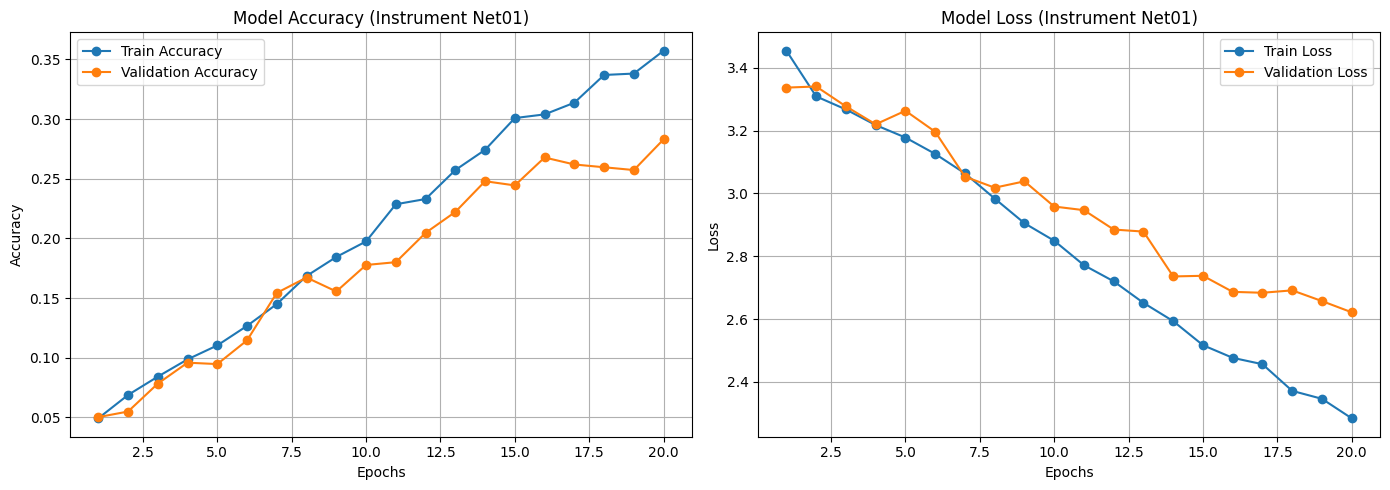

In [73]:
# Extract training history
epochs = list(range(1, len(instrument01_history.history['accuracy']) + 1))

# Create a figure with subplots for accuracy and loss
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot accuracy
axes[0].plot(epochs, instrument01_history.history['accuracy'], marker='o', label='Train Accuracy')
if 'val_accuracy' in instrument01_history.history:
    axes[0].plot(epochs, instrument01_history.history['val_accuracy'], marker='o', label='Validation Accuracy')

axes[0].set_title("Model Accuracy (Instrument Net01)")
axes[0].set_xlabel("Epochs")
axes[0].set_ylabel("Accuracy")
axes[0].legend()
axes[0].grid(True)

# Plot loss
axes[1].plot(epochs, instrument01_history.history['loss'], marker='o', label='Train Loss')
if 'val_loss' in instrument01_history.history:
    axes[1].plot(epochs, instrument01_history.history['val_loss'], marker='o', label='Validation Loss')

axes[1].set_title("Model Loss (Instrument Net01)")
axes[1].set_xlabel("Epochs")
axes[1].set_ylabel("Loss")
axes[1].legend()
axes[1].grid(True)

# Adjust layout and display plots
plt.tight_layout()
plt.show()

## **Improved CNN Model: `instrument_net02`**

A more advanced **CNN architecture** is designed to enhance classification performance.

### **1. Architecture Enhancements**
- **Convolutional Layers:**  
  - **4 Conv2D layers** (32, 64, 128, 256 filters) with ReLU activation.  
  - **Batch Normalization** improves stability.  
  - **MaxPooling** reduces dimensionality.  
- **Fully Connected Layers:**  
  - **150, 70, 50, and 30 neurons** with ReLU activation.  
  - **Dropout (0.3)** for regularization.  
- **Output Layer:**  
  - **Softmax activation** for 30 instrument classes.

### **2. Training & Performance**
- **Trained for 20 epochs** with **class weighting** and **early stopping**.  
- **Final Validation Accuracy: ~77.7%** (significant improvement over baseline).  
- **Loss decreases consistently**, showing strong learning.  
- Model reaches optimal performance at **Epoch 16**.

This CNN model shows **clear improvements**, though further tuning and augmentation may help optimize results.


In [ ]:
# Use global seed for reproducibility
np.random.seed(GLOBAL_SEED)
tf.random.set_seed(GLOBAL_SEED)

# Define the number of instrument classes
num_classes = 30

# Define an improved CNN model (Instrument Net 02)
instrument_net02 = models.Sequential([
    tf.keras.Input(shape=(224, 224, 3)),

    # Improved CNN Feature Extractor
    layers.Conv2D(32, (3,3), activation='relu', padding='same', name='conv1'),
    layers.MaxPooling2D(pool_size=(2,2), name='pool1'),
    layers.BatchNormalization(),

    layers.Conv2D(64, (3,3), activation='relu', padding='same', name='conv2'),
    layers.MaxPooling2D(pool_size=(2,2), name='pool2'),
    layers.BatchNormalization(),

    layers.Conv2D(128, (3,3), activation='relu', padding='same', name='conv3'),
    layers.MaxPooling2D(pool_size=(2,2), name='pool3'),
    layers.BatchNormalization(),

    layers.Conv2D(256, (3,3), activation='relu', padding='same', name='conv4'),
    layers.MaxPooling2D(pool_size=(2,2), name='pool4'),
    layers.BatchNormalization(),

    # Flatten extracted features
    layers.Flatten(name='flatten_layer'),

    # Fully Connected Layers
    layers.Dense(150, activation='relu', name='hidden1'),
    layers.Dropout(0.3, name='dropout1'),

    layers.Dense(70, activation='relu', name='hidden2'),
    layers.Dropout(0.3, name='dropout2'),

    layers.Dense(50, activation='relu', name='hidden3'),
    layers.Dense(30, activation='relu', name='hidden4'),

    # Output Layer
    layers.Dense(num_classes, activation='softmax', name='output_layer')
], name='instrument_net02')

# Compile model with Adam optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
instrument_net02.compile(optimizer=optimizer,
                         loss='categorical_crossentropy',
                         metrics=['accuracy'])

# Display model summary
instrument_net02.summary()

Model: "instrument_net02"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1 (Conv2D)                       │ (None, 224, 224, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pool1 (MaxPooling2D)                 │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 112, 112, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2 (Conv2D)                       │ (None, 112, 112, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pool2 (MaxPooling2D)                 │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 56, 56, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3 (Conv2D)                       │ (None, 56, 56, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pool3 (MaxPooling2D)                 │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 28, 28, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv4 (Conv2D)                       │ (None, 28, 28, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pool4 (MaxPooling2D)                 │ (None, 14, 14, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 14, 14, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_layer (Flatten)              │ (None, 50176)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ hidden1 (Dense)                      │ (None, 150)                 │       7,526,550 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout1 (Dropout)                   │ (None, 150)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ hidden2 (Dense)                      │ (None, 70)                  │          10,570 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout2 (Dropout)                   │ (None, 70)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ hidden3 (Dense)                      │ (None, 50)                  │           3,550 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ hidden4 (Dense)                      │ (None, 30)                  │           1,530 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 7,933,466 (30.26 MB)

 Trainable params: 7,932,506 (30.26 MB)

 Non-trainable params: 960 (3.75 KB)

In [ ]:
# Train the model using the new dataset setup
instrument02_history = instrument_net02.fit(
        train_dataset,
        validation_data=valid_dataset,
        epochs=20,
        class_weight=class_weight_dict,
        callbacks=[early_stopping],
        verbose=1
)

Epoch 1/20
214/214 ━━━━━━━━━━━━━━━━━━━━ 32s 61ms/step - accuracy: 0.0583 - loss: 3.4990 - val_accuracy: 0.0456 - val_loss: 3.5277
Epoch 2/20
214/214 ━━━━━━━━━━━━━━━━━━━━ 13s 21ms/step - accuracy: 0.1483 - loss: 3.0964 - val_accuracy: 0.1719 - val_loss: 3.1164
Epoch 3/20
214/214 ━━━━━━━━━━━━━━━━━━━━ 12s 21ms/step - accuracy: 0.2290 - loss: 2.8026 - val_accuracy: 0.3439 - val_loss: 2.5109
Epoch 4/20
214/214 ━━━━━━━━━━━━━━━━━━━━ 13s 21ms/step - accuracy: 0.2907 - loss: 2.5110 - val_accuracy: 0.4140 - val_loss: 2.1937
Epoch 5/20
214/214 ━━━━━━━━━━━━━━━━━━━━ 13s 21ms/step - accuracy: 0.3623 - loss: 2.2224 - val_accuracy: 0.4865 - val_loss: 1.9477
Epoch 6/20
214/214 ━━━━━━━━━━━━━━━━━━━━ 12s 21ms/step - accuracy: 0.4421 - loss: 1.9432 - val_accuracy: 0.5450 - val_loss: 1.7133
Epoch 7/20
214/214 ━━━━━━━━━━━━━━━━━━━━ 13s 21ms/step - accuracy: 0.5046 - loss: 1.6962 - val_accuracy: 0.6211 - val_loss: 1.5205
Epoch 8/20
214/214 ━━━━━━━━━━━━━━━━━━━━ 12s 21ms/step - accuracy: 0.5638 - loss: 1.4672 - 

## **CNN Model Performance Evaluation (`instrument_net02`)**

### **1. Test Set Results**
- **Test Accuracy:** **~74.62%**  
- **Test Loss:** **1.06**  
- Shows **significant improvement** over the baseline model.

### **2. Training Performance Analysis**
- **Accuracy Plot:**  
  - Both **train and validation accuracy improve steadily**, with validation stabilizing around **77%**.  
- **Loss Plot:**  
  - Training loss **continues to decrease**, but **validation loss stabilizes** after ~15 epochs, suggesting **early stopping was effective**.  

### **3. Key Takeaways**
- **Much better generalization** than `instrument_net01`.  
- **Possible overfitting signs** as validation loss flattens—further tuning (dropout, regularization) could improve robustness.  
- **Next steps:** Experiment with **data augmentation** and **deeper architectures** for further refinement.


In [ ]:
# Evaluate instrument_net02 on the test dataset
test_loss, test_acc = instrument_net02.evaluate(
    test_dataset,
    verbose=1
)

# Print test accuracy and loss
print(f"Test Accuracy (Instrument Net02): {test_acc*100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")

29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.7459 - loss: 1.1401
Test Accuracy (Instrument Net02): 74.62%
Test Loss: 1.0641


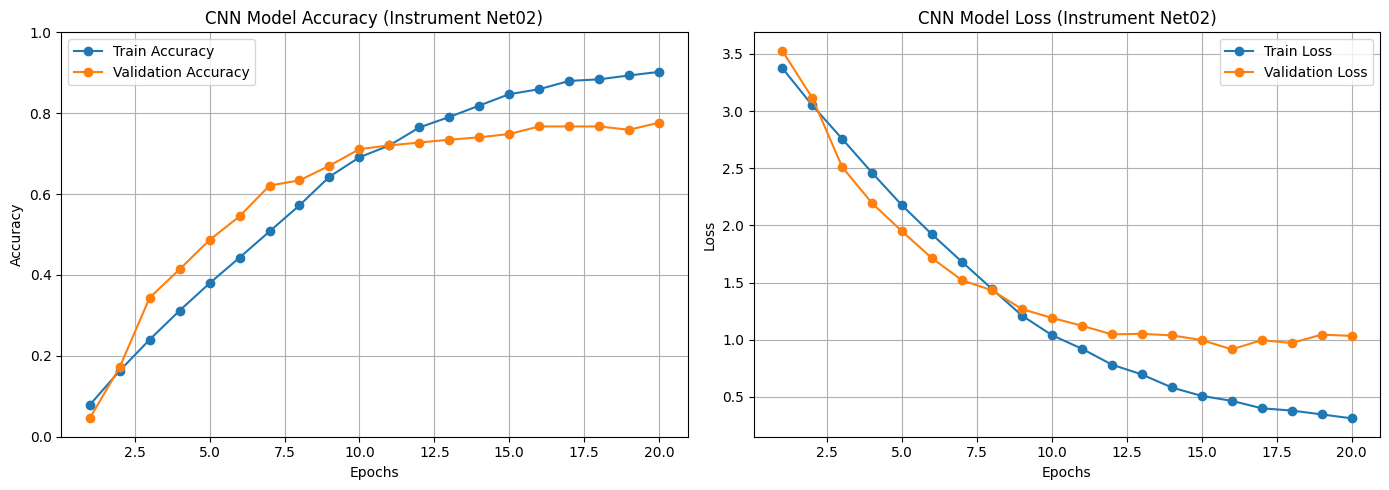

In [74]:
# Extract accuracy & loss data
epochs = list(range(1, len(instrument02_history.history['accuracy']) + 1))
train_acc = instrument02_history.history['accuracy']
val_acc = instrument02_history.history['val_accuracy']
train_loss = instrument02_history.history['loss']
val_loss = instrument02_history.history['val_loss']

# Create a figure with subplots for accuracy and loss
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot accuracy
axes[0].plot(epochs, train_acc, marker='o', label='Train Accuracy')
axes[0].plot(epochs, val_acc, marker='o', label='Validation Accuracy')
axes[0].set_title("CNN Model Accuracy (Instrument Net02)")
axes[0].set_xlabel("Epochs")
axes[0].set_ylabel("Accuracy")
axes[0].set_ylim([0, 1])  # Set y-axis range for accuracy
axes[0].legend()
axes[0].grid(True)

# Plot loss
axes[1].plot(epochs, train_loss, marker='o', label='Train Loss')
axes[1].plot(epochs, val_loss, marker='o', label='Validation Loss')
axes[1].set_title("CNN Model Loss (Instrument Net02)")
axes[1].set_xlabel("Epochs")
axes[1].set_ylabel("Loss")
axes[1].legend()
axes[1].grid(True)

# Adjust layout and display plots
plt.tight_layout()
plt.show()

## **Confusion Matrix Analysis (`instrument_net02`)**

### **1. Interpretation**
- The **diagonal dominance** indicates that the model is correctly classifying many instrument categories.
- Some **misclassifications** occur, suggesting overlap between similar instruments.

### **2. Observations**
- Certain instruments (e.g., **violin, saxophone, drums**) show **strong classification accuracy**.
- **Confusion exists between similar-sounding or visually similar instruments**, such as **trumpet & trombone** or **guitar & banjo**.

### **3. Next Steps**
- **Further tuning** (e.g., **data augmentation, additional CNN layers**) could help refine classification.
- **Class imbalance adjustments** may improve performance for less common instruments.

This visualization provides key insights into **where the model excels and struggles**, guiding further improvements.


29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step


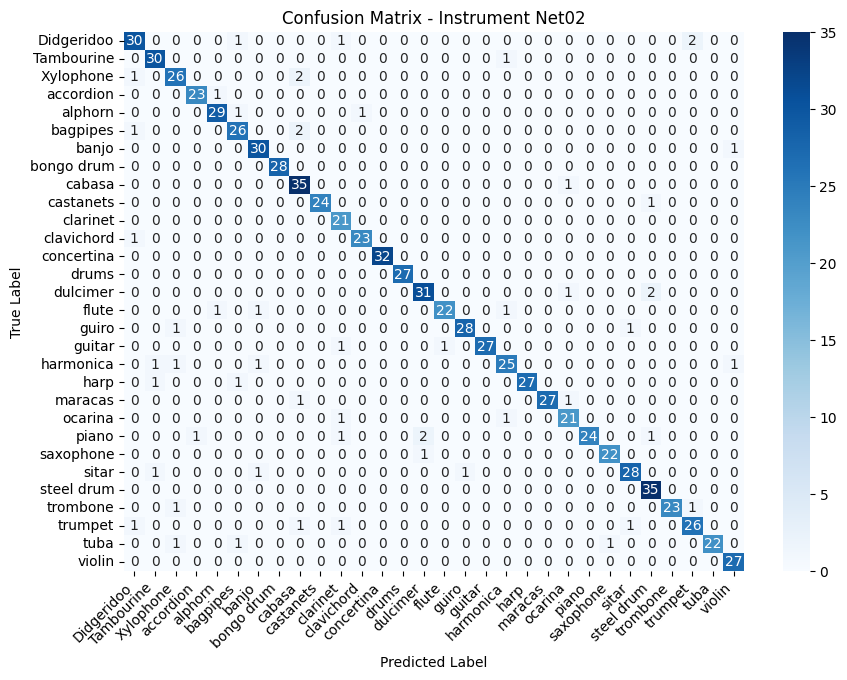

In [75]:
# Extract true labels from test dataset
true_labels = np.concatenate([y.numpy().argmax(axis=1) for _, y in test_dataset])

# Generate predictions using instrument_net02
predictions = instrument_net02.predict(test_dataset, verbose=1)
predicted_labels = np.argmax(predictions, axis=1)  # Convert softmax probabilities to class labels

# Compute confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Convert class indices to labels for readability
class_labels = list(class_to_index.keys())

# Plot confusion matrix using Seaborn
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.title("Confusion Matrix - Instrument Net02")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)

# Show plot
plt.show()

## **Final Manually Tuned CNN: `instrument_net03`**

An improved **CNN model**, fine-tuned from `instrument_net02`, incorporating **RMSprop optimizer** for better weight adjustments.

### **1. Key Enhancements**
- **Same architecture as `instrument_net02`** (4 Conv2D layers, BatchNorm, Dense layers).
- **Switched optimizer to RMSprop** (`learning_rate=0.0001, rho=0.9`) for better gradient updates.
- **Dropout layers retained** (0.3) to mitigate overfitting.

### **2. Training Performance**
- **Trained for 20 epochs**, best performance at **Epoch 16**.
- **Final Validation Accuracy:** **~75.6%** (slightly improved over `instrument_net02`).
- **Loss stabilizes, but room for refinement** (possible further tuning or data augmentation).

### **3. Takeaways**
- **Marginal improvement over `instrument_net02`**—suggests **RMSprop offers similar optimization**.
- **Further improvements may require architecture changes** (e.g., deeper CNN, transfer learning).


In [ ]:
# Use global seed for reproducibility
np.random.seed(GLOBAL_SEED)
tf.random.set_seed(GLOBAL_SEED)

# Define manually tuned CNN model (Instrument Net 03, Based on Net02 with RMSprop)
instrument_net03 = models.Sequential([
    tf.keras.Input(shape=(224, 224, 3)),  # Input Layer

    # Convolutional Layers (Retaining net02 architecture)
    layers.Conv2D(32, (3,3), activation='relu', padding='same', name='conv1'),
    layers.MaxPooling2D(pool_size=(2,2), name='pool1'),
    layers.BatchNormalization(),

    layers.Conv2D(64, (3,3), activation='relu', padding='same', name='conv2'),
    layers.MaxPooling2D(pool_size=(2,2), name='pool2'),
    layers.BatchNormalization(),

    layers.Conv2D(128, (3,3), activation='relu', padding='same', name='conv3'),
    layers.MaxPooling2D(pool_size=(2,2), name='pool3'),
    layers.BatchNormalization(),

    layers.Conv2D(256, (3,3), activation='relu', padding='same', name='conv4'),
    layers.MaxPooling2D(pool_size=(2,2), name='pool4'),
    layers.BatchNormalization(),

    # Flatten extracted features
    layers.Flatten(name='flatten_layer'),

    # Fully Connected Layers (Retaining instrument_net02 dense layers)
    layers.Dense(150, activation='relu', name='hidden1'),
    layers.Dropout(0.3, name='dropout1'),

    layers.Dense(70, activation='relu', name='hidden2'),
    layers.Dropout(0.3, name='dropout2'),

    layers.Dense(50, activation='relu', name='hidden3'),
    layers.Dense(30, activation='relu', name='hidden4'),

    # Output Layer
    layers.Dense(30, activation='softmax', name='output_layer')
], name='instrument_net03')

# Compile model with manually tuned RMSprop optimizer
optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.0001, rho=0.9)
instrument_net03.compile(optimizer=optimizer,
                         loss='categorical_crossentropy',
                         metrics=['accuracy'])

# Display model summary
instrument_net03.summary()

Model: "instrument_net03"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1 (Conv2D)                       │ (None, 224, 224, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pool1 (MaxPooling2D)                 │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 112, 112, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2 (Conv2D)                       │ (None, 112, 112, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pool2 (MaxPooling2D)                 │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 56, 56, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3 (Conv2D)                       │ (None, 56, 56, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pool3 (MaxPooling2D)                 │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 28, 28, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv4 (Conv2D)                       │ (None, 28, 28, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pool4 (MaxPooling2D)                 │ (None, 14, 14, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 14, 14, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_layer (Flatten)              │ (None, 50176)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ hidden1 (Dense)                      │ (None, 150)                 │       7,526,550 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout1 (Dropout)                   │ (None, 150)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ hidden2 (Dense)                      │ (None, 70)                  │          10,570 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout2 (Dropout)                   │ (None, 70)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ hidden3 (Dense)                      │ (None, 50)                  │           3,550 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ hidden4 (Dense)                      │ (None, 30)                  │           1,530 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 7,933,466 (30.26 MB)

 Trainable params: 7,932,506 (30.26 MB)

 Non-trainable params: 960 (3.75 KB)

In [ ]:
# Train the model
instrument03_history = instrument_net03.fit(
        train_dataset,
        validation_data=valid_dataset,
        epochs=20,
        class_weight=class_weight_dict,
        callbacks=[early_stopping],
        verbose=1
)

Epoch 1/20
214/214 ━━━━━━━━━━━━━━━━━━━━ 25s 46ms/step - accuracy: 0.0659 - loss: 3.4717 - val_accuracy: 0.0363 - val_loss: 3.4561
Epoch 2/20
214/214 ━━━━━━━━━━━━━━━━━━━━ 13s 21ms/step - accuracy: 0.1568 - loss: 3.0174 - val_accuracy: 0.2433 - val_loss: 2.9086
Epoch 3/20
214/214 ━━━━━━━━━━━━━━━━━━━━ 13s 21ms/step - accuracy: 0.2573 - loss: 2.6553 - val_accuracy: 0.4070 - val_loss: 2.3125
Epoch 4/20
214/214 ━━━━━━━━━━━━━━━━━━━━ 13s 21ms/step - accuracy: 0.3494 - loss: 2.3519 - val_accuracy: 0.4702 - val_loss: 2.0656
Epoch 5/20
214/214 ━━━━━━━━━━━━━━━━━━━━ 12s 20ms/step - accuracy: 0.4316 - loss: 2.0071 - val_accuracy: 0.5556 - val_loss: 1.7756
Epoch 6/20
214/214 ━━━━━━━━━━━━━━━━━━━━ 12s 20ms/step - accuracy: 0.4993 - loss: 1.7328 - val_accuracy: 0.6035 - val_loss: 1.5977
Epoch 7/20
214/214 ━━━━━━━━━━━━━━━━━━━━ 12s 21ms/step - accuracy: 0.5776 - loss: 1.4818 - val_accuracy: 0.6351 - val_loss: 1.4355
Epoch 8/20
214/214 ━━━━━━━━━━━━━━━━━━━━ 12s 20ms/step - accuracy: 0.6154 - loss: 1.3007 - 

## **Confusion Matrix Analysis (`instrument_net03`)**

### **1. Model Performance**
- **Test Accuracy:** **~73.2%**  
- **Test Loss:** **1.22**  
- Performance is **comparable to `instrument_net02`**, suggesting minimal impact from switching optimizers.

### **2. Confusion Matrix Insights**
- The model correctly identifies most instruments, with **strong diagonal alignment**.
- **Misclassifications occur in similar-sounding or visually alike instruments** (e.g., brass and string groups).

### **3. Next Steps**
- **Further fine-tuning** (e.g., learning rate adjustments, deeper CNN layers).  
- **Experiment with data augmentation** to enhance generalization.  
- **Consider pre-trained models** (e.g., transfer learning) for improved feature extraction.

While the model shows **solid classification ability**, additional refinements could enhance accuracy further.

In [ ]:
# Evaluate instrument_net03 on the test dataset
test_loss, test_acc = instrument_net03.evaluate(
    test_dataset,
    verbose=1
)

# Print test accuracy and loss
print(f"Test Accuracy (Instrument Net03): {test_acc*100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")

29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.7487 - loss: 1.1889
Test Accuracy (Instrument Net03): 73.22%
Test Loss: 1.2227


29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step


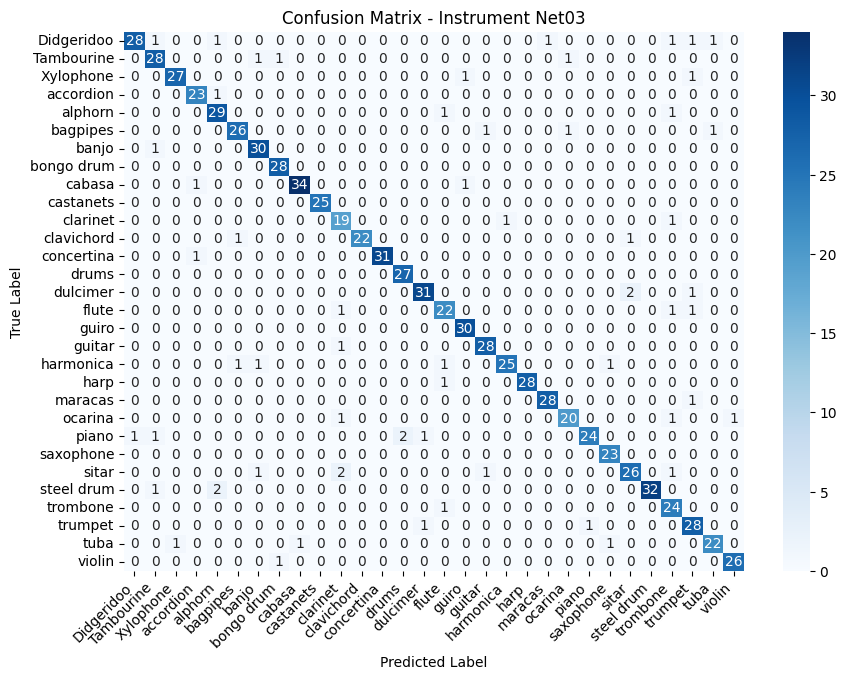

In [76]:
# Extract true labels from test dataset
true_labels = np.concatenate([y.numpy().argmax(axis=1) for _, y in test_dataset])

# Generate predictions using instrument_net03
predictions = instrument_net03.predict(test_dataset, verbose=1)
predicted_labels = np.argmax(predictions, axis=1)  # Convert softmax probabilities to class labels

# Compute confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Convert class indices to labels for readability
class_labels = list(class_to_index.keys())

# Plot confusion matrix using Seaborn
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.title("Confusion Matrix - Instrument Net03")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)

# Show plot
plt.show()

## **Comparison: `instrument_net02` vs `instrument_net03`**

### **1. Accuracy Comparison**
- **Both models show steady improvement**, but `instrument_net03` **converges faster** in early epochs.
- **Final training accuracy** is slightly higher for `instrument_net03`, but **validation accuracy remains similar**, suggesting **comparable generalization**.

### **2. Loss Comparison**
- `instrument_net03` achieves **lower training loss**, indicating **better optimization**.
- **Validation loss remains close**, suggesting **limited overfitting improvements**.

### **3. Key Takeaways**
- **Minimal impact** from optimizer change (Adam → RMSprop).
- **Further enhancements** (e.g., deeper layers, learning rate tuning) may be needed for noticeable improvements.
- **Potential next step:** Apply **transfer learning** for enhanced feature extraction.

Overall, **`instrument_net03` optimizes better during training, but validation results remain similar**—highlighting the need for architectural refinements.


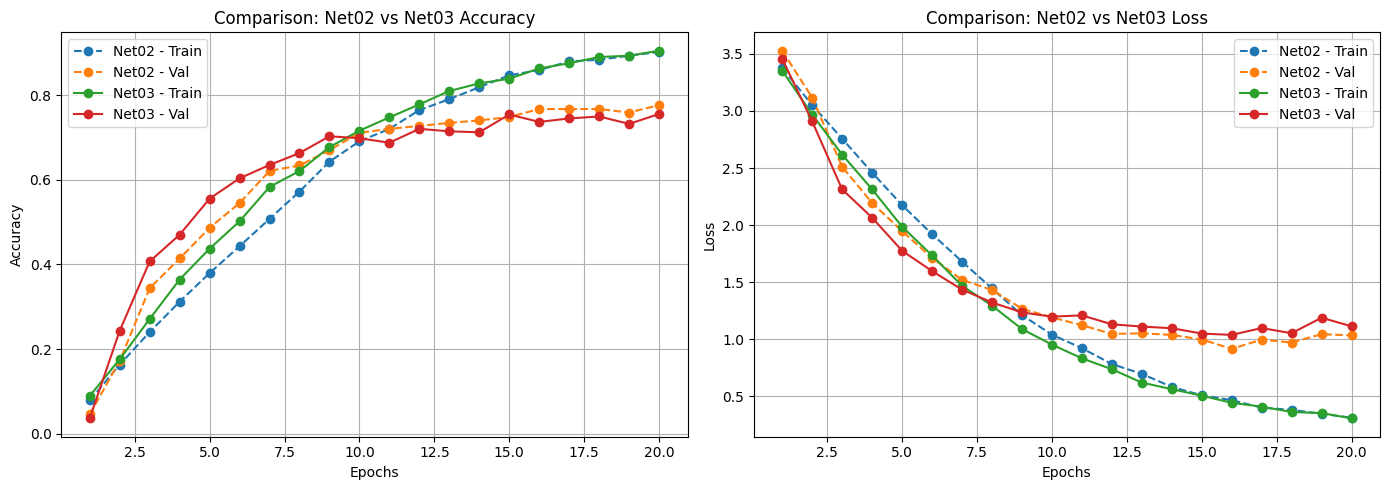

In [77]:
# Extract epochs
epochs = list(range(1, len(instrument02_history.history['accuracy']) + 1))

# Create figure with subplots for accuracy and loss comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot accuracy comparison
axes[0].plot(epochs, instrument02_history.history['accuracy'], marker='o', linestyle='dashed', label='Net02 - Train')
axes[0].plot(epochs, instrument02_history.history['val_accuracy'], marker='o', linestyle='dashed', label='Net02 - Val')

axes[0].plot(epochs, instrument03_history.history['accuracy'], marker='o', label='Net03 - Train')
axes[0].plot(epochs, instrument03_history.history['val_accuracy'], marker='o', label='Net03 - Val')

axes[0].set_title("Comparison: Net02 vs Net03 Accuracy")
axes[0].set_xlabel("Epochs")
axes[0].set_ylabel("Accuracy")
axes[0].legend()
axes[0].grid(True)

# Plot loss comparison
axes[1].plot(epochs, instrument02_history.history['loss'], marker='o', linestyle='dashed', label='Net02 - Train')
axes[1].plot(epochs, instrument02_history.history['val_loss'], marker='o', linestyle='dashed', label='Net02 - Val')

axes[1].plot(epochs, instrument03_history.history['loss'], marker='o', label='Net03 - Train')
axes[1].plot(epochs, instrument03_history.history['val_loss'], marker='o', label='Net03 - Val')

axes[1].set_title("Comparison: Net02 vs Net03 Loss")
axes[1].set_xlabel("Epochs")
axes[1].set_ylabel("Loss")
axes[1].legend()
axes[1].grid(True)

# Adjust layout and display plots
plt.tight_layout()
plt.show()

## **Brief Summary of Results**

- **Both `instrument_net02` and `instrument_net03` perform well** on test samples, with `Net03` showing slightly improved optimization.
- **Correct classifications** are highlighted in **green**, while **misclassifications** appear in **red**.
- **Performance Differences:**
  - **Most predictions are consistent across both models**, confirming similar classification abilities.
  - **Misclassifications are present**, especially in visually similar instruments.
  - **`Net03` demonstrates minor improvements**, but no significant edge over `Net02`.

### **Key Takeaways**
- **Both models generalize well**, but further **fine-tuning or transfer learning** may enhance performance.
- **Class confusion remains an issue**, particularly for visually alike instruments.
- **Next Steps:** Experiment with **data augmentation** and **more advanced architectures** for better generalization.


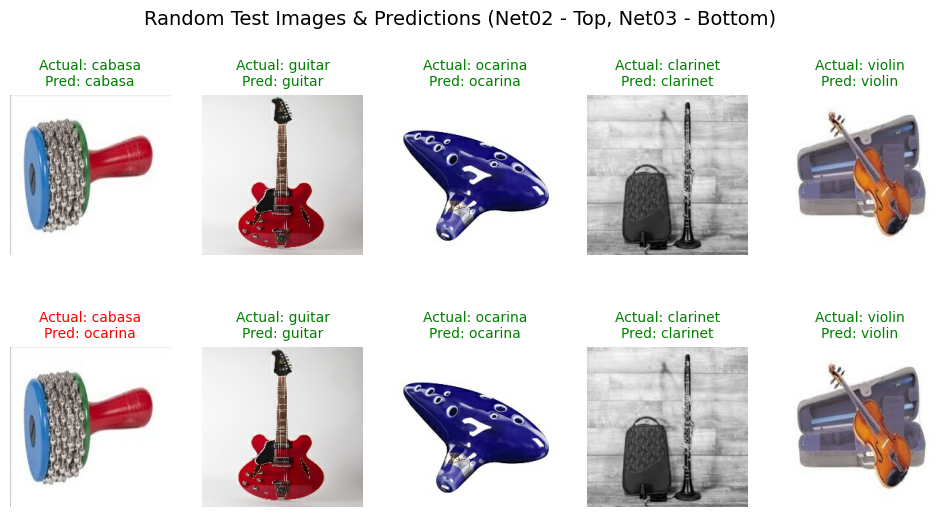

In [ ]:
# Extract class labels from dataset
class_labels = list(class_to_index.keys())

# Randomly select a few images from the test dataset
num_samples = 5
test_images, test_labels = [], []

# Take one batch from the test dataset
for batch_x, batch_y in test_dataset.take(1):
    indices = random.sample(range(len(batch_x)), num_samples)
    test_images = batch_x.numpy()[indices]
    test_labels = batch_y.numpy()[indices].argmax(axis=1)

# Generate predictions using Net02
predictions_net02 = instrument_net02.predict(test_images, verbose=0)
predicted_labels_net02 = np.argmax(predictions_net02, axis=1)

# Generate predictions using Net03
predictions_net03 = instrument_net03.predict(test_images, verbose=0)
predicted_labels_net03 = np.argmax(predictions_net03, axis=1)

# Plot the images with predicted & actual labels for Net02
plt.figure(figsize=(12, 6))
for i in range(num_samples):
    plt.subplot(2, num_samples, i + 1)
    plt.imshow(test_images[i])
    plt.axis("off")
    actual = class_labels[test_labels[i]]
    predicted = class_labels[predicted_labels_net02[i]]
    plt.title(f"Actual: {actual}\nPred: {predicted}", fontsize=10, color="green" if actual == predicted else "red")

plt.suptitle("Random Test Images & Predictions (Net02)", fontsize=14)

# Plot the images with predicted & actual labels for Net03
for i in range(num_samples):
    plt.subplot(2, num_samples, num_samples + i + 1)
    plt.imshow(test_images[i])
    plt.axis("off")
    actual = class_labels[test_labels[i]]
    predicted = class_labels[predicted_labels_net03[i]]
    plt.title(f"Actual: {actual}\nPred: {predicted}", fontsize=10, color="green" if actual == predicted else "red")

plt.suptitle("Random Test Images & Predictions (Net02 - Top, Net03 - Bottom)", fontsize=14)
plt.show()

In [78]:
# Convert the notebook to HTML
!jupyter nbconvert --to html "/content/drive/My Drive/DAT_402_Project_02/Project_02.ipynb"

# Download the converted file
from google.colab import files
files.download("/content/drive/My Drive/DAT_402_Project_02/Project_02.html")

[NbConvertApp] Converting notebook /content/drive/My Drive/DAT_402_Project_02/Project_02.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 10 image(s).
[NbConvertApp] Writing 4105463 bytes to /content/drive/My Drive/DAT_402_Project_02/Project_02.html


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>